In [1]:
import os
import ast
import re
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from datetime import datetime
from jmetal.core.problem import IntegerProblem
from jmetal.core.solution import IntegerSolution
from jmetal.util.observer import ProgressBarObserver
from jmetal.operator.crossover import IntegerSBXCrossover
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.operator.mutation import IntegerPolynomialMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import (
    get_non_dominated_solutions,
    print_function_values_to_file,
    print_variables_to_file,
)

In [2]:
file1 = open("variables.txt","r")
variable_data=file1.readlines()
variable_dict=dict()
for element in variable_data:
    element_list=element.strip().replace(";","").split(":")
    key=element_list[0].strip()
    value=ast.literal_eval(element_list[1].strip())
    variable_dict[key]=value
mapping_dict=dict()
for key in variable_dict.keys():
    mapping_dict[key]=list(range(len(variable_dict[key])))
variable_list=[]
for value in variable_dict.values():
    variable_list.extend(value)
mapping_list=[]
for value in mapping_dict.values():
    mapping_list.extend(value)

In [3]:
file2 = open("rules.txt","r")
rules_data=file2.readlines()
string="".join(rules_data)
string=string.replace("\n","")
string=re.sub(r'/\* Rule \d+  \*/',"", string)
matches = set(re.findall(r'"([^"]*)"', string))
for element in matches:
        index=variable_list.index(element)
        string=string.replace(f'"{element}"',str(mapping_list[index]))
rules=string.split(";")[:-1]
rule_list=[]
for rule in rules:
    rule=rule[1:-1].strip().replace("=","==")
    rule_list.append(rule.split("or"))
print(len(rule_list))

113


In [4]:
def remove_odd_parentheses(input_string):
    opening_count = 0
    closing_count = 0
    for char in input_string:
        if char == '(':
            opening_count += 1
        elif char == ')':
            closing_count += 1
    if opening_count % 2 == 0:
        input_string = input_string.replace('(', '', 1)  
    if closing_count % 2 == 0:
        input_string = input_string[::-1].replace(')', '', 1)[::-1]  
    return input_string

In [5]:
for i in range(len(rule_list)):
    for j in range(len(rule_list[i])):
        rule_list[i][j]=remove_odd_parentheses(rule_list[i][j]).strip()

In [6]:
# assumption={"Var1" : 2,"Var2" : 1,"Var3" : 0, "Var4" : 1, "Var5" : 8,"Var6" : 0, "Var7" : 1, "Var8" : 0, "Var9" : 1,"Var10" : 0, "Var11" : 0, "Var12" : 0, "Var13" : 1, "Var14" : 1, "Var15" : 0, "Var16" : 1, "Var17" : 0, "Var18" : 1, "Var19" : 1, 
# "Var20" : 1, "Var21" : 1, "Var22" : 1, "Var23" : 1, "Var24" : 1, "Var25" : 2, "Var26" : 2, "Var27" : 2, "Var28" : 2, "Var29" : 1, "Var30" : 0, "Var31" : 5, "Var32" : 1, "Var33" : 0, "Var34" : 2, "Var35" : 0, "Var36" : 0, "Var39" : 0, "Var40" : 2, "Var41" : 0, "Var42" : 1, "Var43" : 2, "Var44" : 2, "Var45" : 0, "Var46" : 1, "Var47" : 1, "Var48" : 1, "Var49" : 1, "Var50" : 0, 
# "Var51" : 0, "Var52" : 3, "Var53" : 1, "Var54" : 0, "Var55" : 1, "Var56" : 1, "Var57" : 0, "Var58" : 5, "Var59" : 0,"Var60" : 1, "Var61" : 1, "Var62" : 1, "Var63" : 1, "Var64" : 4, "Var65" : 1, "Var66" : 1, 
# "Var67" : 4, "Var68" : 1, "Var69" : 1, "Var70" : 1, "Var71" : 1, "Var72" : 1, "Var73" : 1, "Var74" : 3, "Var75" : 5, "Var76" : 1, "Var77" : 1, "Var78" : 1, "Var79" : 1, "Var80" : 1, "Var81" : 1, "Var82" : 4, "Var83" : 1, "Var84" : 0, "Var85" : 0, "Var86" : 0, "Var87" : 0, "Var88" : 0, "Var89" : 0, "Var90" : 1, "Var91" : 0, "Var92" : 3, "Var93" : 1, "Var94" : 0, "Var95" : 3, "Var96" : 4, "Var97" : 1, "Var98" : 2, "Var99" : 3, "Var100" : 6, 
# "Var101" : 5 }
# count=0
# for i in range(len(rule_list)):
#     rules_copy=rule_list[i].copy()
#     for j in range(len(rules_copy)):        
#         for var, value in assumption.items():
#             rules_copy[j] = rules_copy[j].replace(f"{var} ", str(value))
#         if eval(rules_copy[j]):
#             count+=1
#             break
# print(count)

In [7]:
LOG_FILE = f"{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}.log"
logs_path = os.path.join(os.getcwd(),"renault_logs")
LOG_FILE_PATH = os.path.join(logs_path, LOG_FILE)
logging.basicConfig(
    filename=LOG_FILE_PATH,
    format="[ %(asctime)s ] %(name)s - %(levelname)s - %(message)s",
    level=logging.INFO,)

In [8]:
class RenaultProblem(IntegerProblem):
    def __init__(self,variable_dict,rule_list):
            super(RenaultProblem, self).__init__()
            self.number_of_variable = len(variable_dict)
            self.lower_bound = [0]*self.number_of_variable
            self.upper_bound = [len(value) for value in variable_dict.values()]
            self.variable_keys=list(variable_dict.keys())
            self.rule_list=rule_list
            self.number_of_objective = 1
            self.number_of_constraint = 0
            self.obj_directions = [self.MINIMIZE]
            
    def calculate_cost(self,assumption):
        
            count=0
            for i in range(len(self.rule_list)):
                rules_copy=self.rule_list[i].copy()
                for j in range(len(rules_copy)):        
                    for var, value in assumption.items():
                        rules_copy[j] = rules_copy[j].replace(f"{var} ", str(value))
                    if eval(rules_copy[j]):
                        count+=1
                        break
            fitness=113-count
            logging.info(f"Fitness : {fitness}")
            return fitness
        
    def evaluate(self, solution: IntegerSolution) -> IntegerSolution:
       
        assignments=solution.variables
        assumption=dict()
        for i in range(len(assignments)):
            assumption[self.variable_keys[i]]=assignments[i]  
        result=self.calculate_cost(assumption)
        solution.objectives[0] = result
        return solution

    def name(self):
        return "RenaultProblem"
    
    def number_of_objectives(self) -> int:
        return self.number_of_objective

    def number_of_constraints(self) -> int:
        return self.number_of_constraint
    
    def number_of_variables(self) -> int:
        return self.number_of_variable

In [9]:
max_evaluations=900
mutation_prob=1/99
pop_size=90

problem = RenaultProblem(variable_dict=variable_dict,rule_list=rule_list) 

algorithm = NSGAII(
    problem=problem,
    population_size=pop_size,
    offspring_population_size=pop_size,
    mutation=IntegerPolynomialMutation(probability=mutation_prob, distribution_index=5),
    crossover=IntegerSBXCrossover(probability=1.0, distribution_index=1),
    termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations),
)

progress_bar = ProgressBarObserver(max=max_evaluations)
algorithm.observable.register(observer=progress_bar)
algorithm.run()
front = get_non_dominated_solutions(algorithm.get_result())
logging.info(f"Minimum Fitness cost: {front[0].objectives}")
logging.info(f"Minimum Fitness Solution: {front[0].variables}")

[2024-01-30 12:31:07,219] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2024-01-30 12:31:07,225] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2024-01-30 12:41:42,422] [jmetal.core.algorithm] [DEBUG] Initializing progress...
Progress: 100%|#############################| 900/900 [1:18:47<00:00,  5.25s/it]
[2024-01-30 14:00:30,213] [jmetal.core.algorithm] [DEBUG] Finished!


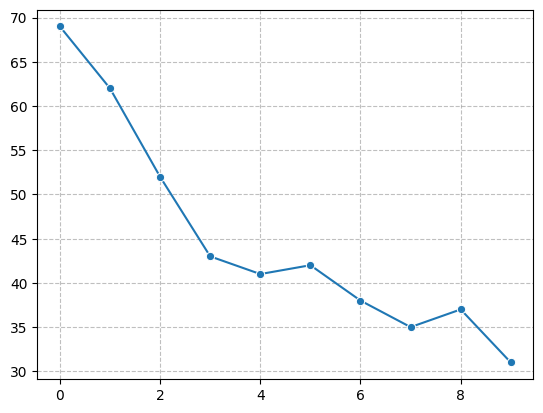

In [63]:
file3=open(LOG_FILE_PATH,"r")
log_data=file3.readlines()
pop_size=90
fitness_data=[]
for data in log_data:
    if "Fitness"in data:
        fitness_data.append(int(re.findall("\d+",data)[-1]))
partitioned_list = [fitness_data[i:i+pop_size] for i in range(0, len(fitness_data), pop_size)]
min_list=[]
for gen in partitioned_list:
    min_list.append(min(gen))
ax=sns.lineplot(x=range(len(min_list)), y=min_list,marker="o")
plt.grid(True, linestyle='--', color='gray', alpha=0.5)
plt.savefig(f'{LOG_FILE_PATH}.png')